## Comparing both strain sensor on Index MCP angle data and IMU on wrist and palm angle data to camera angle data for any of the APPLIED tests

##  Process flow:  

(1) Load data folder

(2) Plot raw calibrated strain sensor on index MCP which was placed on Phil's angle calibration block

(3) Pick data segments (by index) from plot above for each bend angle to build the calibration curve

(4) Sanity check: compare the quadratic ADC–angle fit against the theoretical model.

(5) Apply the quadratic calibration to convert all trial ADC values to angles

(6) Example for how to plot single trial for 1st application and reapplication

(7) Plot all trials together for 1st application and reapplication

(8) Get per-trial camera timestamp tables from flir.mat (prefix 'ts*')

(9) Match trial ADC timestamps to camera trigger timestamps -> need for error analysis (still need DLC 3D data, so this process not complete)

(10) Extract IMU trials (same calls as before)

(11) Compute bend angle from two IMU's and plot


In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from config import path_to_repository
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [78]:
# Upload ball bearing and beaker Trials from particpant
# Upload only the parent *date* folder (e.g., "9_19_25").
# If something fails, verify your folder structure matches the "9_19_25" example.

bb = BallBearingData(
    root_dir="CSV Data/9_19_25", # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=9,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix="R_mar",     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first  = bb.load_first() # first application
df_second = bb.load_second() # reapplication

adc_trials_first = bb.extract_adc_dfs_by_trial(df_first)  # list of DataFrames 
adc_trials_second = bb.extract_adc_dfs_by_trial(df_second)  # list of DataFrames
trial1_adc = adc_trials_first[0]  # trial 1 (index 0)

# upload  csv files for sensor calibration on autobender.  This was only done twice for Tom.  After Tom's experiments, strain sensor only calibrated on Phil's 
# 3D printed block

renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_rotenc_2025_09_09_11_48_41.csv")
strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_adc_2025_09_09_11_48_41.csv")



Found 106 *_R_mar folders total (case-insensitive).
First set range: 2025_09_19_19_41_18_R_mar → 2025_09_19_19_53_19_R_mar
Second set range: 2025_09_19_19_53_19_R_mar → 2025_09_19_20_05_49_R_mar
[WARN] ball_bearing_first: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_09_19_19_41_18_R_mar has 6 CSVs
  • Trial 02: 2025_09_19_19_41_18_R_mar has 6 CSVs
  • Trial 03: 2025_09_19_19_42_57_R_mar has 6 CSVs
  • Trial 04: 2025_09_19_19_42_57_R_mar has 6 CSVs
  • Trial 05: 2025_09_19_19_46_15_R_mar has 6 CSVs
  • Trial 06: 2025_09_19_19_46_15_R_mar has 6 CSVs
  • Trial 07: 2025_09_19_19_52_55_R_mar has 6 CSVs
  • Trial 08: 2025_09_19_19_52_55_R_mar has 6 CSVs
  • Trial 09: 2025_09_19_19_53_19_R_mar has 6 CSVs
First set range: 2025_09_19_19_41_18_R_mar → 2025_09_19_19_53_19_R_mar
Second set range: 2025_09_19_19_53_19_R_mar → 2025_09_19_20_05_49_R_mar
[WARN] ball_bearing_second: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_09_19_19_53_19_R_mar has 6 CSVs
  • Trial 02: 202

## Plot raw calibrated strain sensor on index MCP which was placed on Phil's angle calibration block

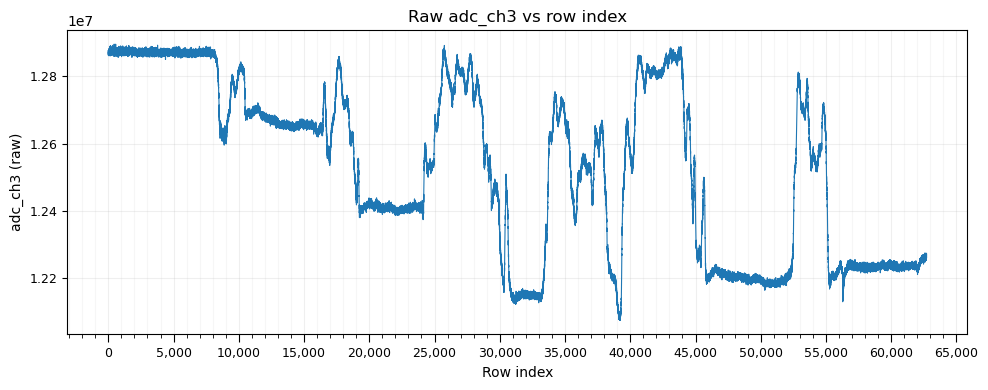

In [80]:
import matplotlib.ticker as mticker

# Analyzing strain sensor block calibration data.  One continuous adc timeseries collected, and mcp is bent sequentually at the following angles:  
# 0, 22.5, 45, 67.5, 90 deg

# --- first calibration Tom---
#h_cal_path = os.path.join(
#    path_to_repository,
#    "CSV Data/9_9_25/block calibration/2025_09_18_09_56_56_R/data_spacebar_2025_09_18_09_56_56.csv"
#)


# --- first calibration Phil---
h_cal_path = os.path.join(
    path_to_repository,
    "CSV Data/9_19_25/09_09_SEN2_hand_block_calib/2025_09_19_18_48_42_R/data_adc_2025_09_19_18_48_42.csv"
)


# Load ADC CSV and plot every point from adc_ch3
adc_df = pd.read_csv(h_cal_path)
y_raw = pd.to_numeric(adc_df["adc_ch3"], errors="coerce")

x = np.arange(len(y_raw))  # row index for every sample

# ---- Plot: raw adc_ch3 vs row index with denser ticks ----
plt.figure(figsize=(10, 4))
plt.plot(x, y_raw.values, linewidth=0.8)

ax = plt.gca()

# 1) More major ticks (aim for ~15 labeled ticks)
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15, prune=None))

# 2) Minor ticks between majors (e.g., 5)
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))

# 3) Make ticks readable
ax.tick_params(axis="x", which="major", length=6)
ax.tick_params(axis="x", which="minor", length=3)
ax.tick_params(axis="both", which="both", labelsize=9)

# 4) Show thousands separators on x
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v):,}"))

plt.xlabel("Row index")
plt.ylabel("adc_ch3 (raw)")
plt.title("Raw adc_ch3 vs row index")
plt.grid(alpha=0.2, which="major")
plt.grid(alpha=0.1, which="minor", axis="x")
plt.tight_layout()
plt.show()


## Pick data segments (by index) from plot above for each bend angle to build the calibration curve

Counts per angle:
angle
0.0     500
22.5    500
45.0    500
90.0    500
Name: adc_ch3, dtype: int64

Quadratic fit: ADC = a + b·θ + c·θ²
  a = 1.26828e+07,  b = -463.231,  c = -67.7375
  R² = 0.997967


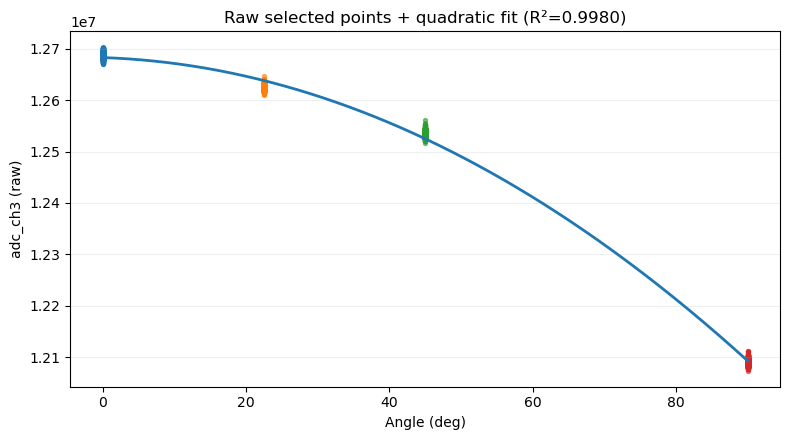

In [82]:
# --- given marker file path  ---
h_cal_path = os.path.join(
    path_to_repository,
    "CSV Data/9_9_25/block calibration/2025_09_18_09_56_56_R/data_spacebar_2025_09_18_09_56_56.csv"
)

# Derive matching ADC file
adc_path = h_cal_path.replace("data_spacebar_", "data_adc_")

# Load ADC CSV and pull adc_ch3 as a numpy array
adc_df = pd.read_csv(adc_path)
y = pd.to_numeric(adc_df["adc_ch3"], errors="coerce").to_numpy()

# === USER INPUT: five (start_row, end_row) ranges, in order of angles ===
# Example (replace with actual row ranges)
ranges = [
    (  0,  500),    # 0°
    (11200,  11700),   # 22.5°
    (22000,  22500),   # 45°
    #(32000,  32500),   # 67.5° was not easy to distiguish from 90 degrees so not used for Phil data
    (50000, 50500),   # 90°
]

angles = [0.0, 22.5, 45.0, 90] # angles actually using

# Optional: keep at most N consecutive points per range (set to None for all)
max_points_per_range = None   # e.g., 200

# --- Build the angle→adc DataFrame ---
parts = []
for (start, end), ang in zip(ranges, angles):
    # clamp to valid indices
    start = int(max(0, start))
    end   = int(min(len(y), end))
    if end <= start:
        continue

    vals = y[start:end]
    # drop NaNs if any
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        continue

    if max_points_per_range is not None and vals.size > max_points_per_range:
        # choose the flattest consecutive window of length max_points_per_range
        k = max_points_per_range
        c1 = np.concatenate(([0.0], np.cumsum(vals)))
        c2 = np.concatenate(([0.0], np.cumsum(vals*vals)))
        sum_y  = c1[k:] - c1[:-k]
        sum_y2 = c2[k:] - c2[:-k]
        mean_y = sum_y / k
        var_y  = np.maximum(sum_y2 / k - mean_y**2, 0.0)
        i0 = int(np.argmin(var_y))
        vals = vals[i0:i0+k]

    parts.append(pd.DataFrame({"angle": ang, "adc_ch3": vals}))

angle_adc_df = (pd.concat(parts, ignore_index=True)
                if parts else pd.DataFrame(columns=["angle","adc_ch3"]))

# --- Quick summary ---
print("Counts per angle:")
print(angle_adc_df.groupby("angle")["adc_ch3"].size())

# === Quadratic fit on selected points (ADC = a + b*theta + c*theta^2) + R^2 ===
if not angle_adc_df.empty and angle_adc_df["angle"].nunique() >= 3:
    x_fit = angle_adc_df["angle"].to_numpy(float)
    y_fit = angle_adc_df["adc_ch3"].to_numpy(float)

    # Fit returns [c2, c1, c0] for c2*x^2 + c1*x + c0
    c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)
    y_hat = c0 + c1*x_fit + c2*(x_fit**2)

    ss_res = np.sum((y_fit - y_hat)**2)
    ss_tot = np.sum((y_fit - y_fit.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    print("\nQuadratic fit: ADC = a + b·θ + c·θ²")
    print(f"  a = {c0:.6g},  b = {c1:.6g},  c = {c2:.6g}")
    print(f"  R² = {r2:.6f}")

    # --- Single plot: raw points (vertical bands) + fitted curve ---
    plt.figure(figsize=(8,4.5))
    for ang in angles:
        yy_band = angle_adc_df.loc[angle_adc_df["angle"] == ang, "adc_ch3"].to_numpy()
        if yy_band.size:
            xx_band = np.full_like(yy_band, ang, dtype=float)
            plt.scatter(xx_band, yy_band, s=8, alpha=0.6)

    xx = np.linspace(min(angles), max(angles), 300)
    yy_curve = c0 + c1*xx + c2*(xx**2)
    plt.plot(xx, yy_curve, linewidth=2)

    plt.xlabel("Angle (deg)")
    plt.ylabel("adc_ch3 (raw)")
    plt.title(f"Raw selected points + quadratic fit (R²={r2:.4f})")
    plt.grid(alpha=0.2, axis="y")
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to fit (need points from ≥3 distinct angles).")




## Sanity check: compare the quadratic ADC–angle fit against the theoretical model.


Quadratic fit on selected points: ADC = a + b·θ + c·θ²
  a = 1.26828e+07,  b = -463.231,  c = -67.7375
  R² = 0.997967
Loaded merged_df with 2000 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.9211 in  (95% CI: 0.9149, 0.9273),  R²=0.9965


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:1606: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:1607: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


Loaded merged_df with 6505 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.3253 in  (95% CI: 0.3210, 0.3296),  R²=0.9927


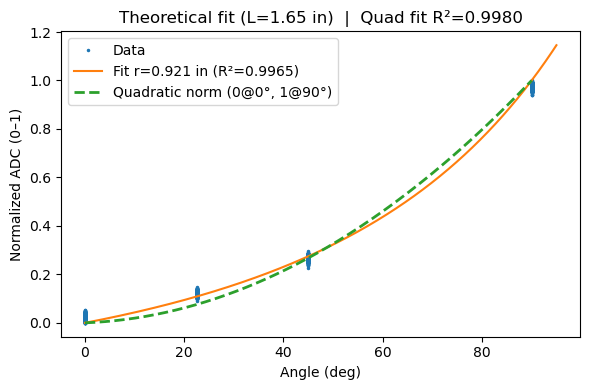

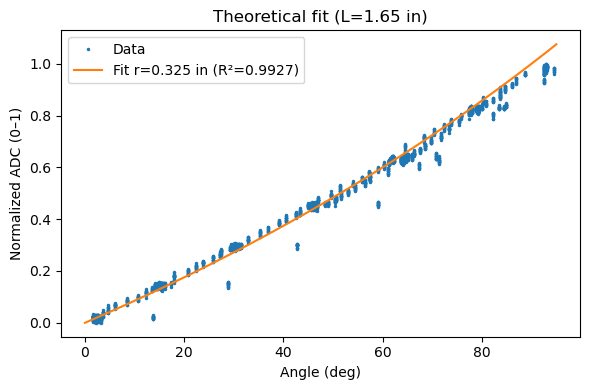

In [84]:


# 1) Quadratic fit on selected raw points: ADC = a + b*theta + c*theta^2
x_fit = angle_adc_df["angle"].to_numpy(float)
y_fit = angle_adc_df["adc_ch3"].to_numpy(float)

c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)  # returns [c2, c1, c0]
p = np.poly1d([c2, c1, c0])
y_hat = p(x_fit)

ss_res = np.sum((y_fit - y_hat)**2)
ss_tot = np.sum((y_fit - y_fit.mean())**2)
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

print("\nQuadratic fit on selected points: ADC = a + b·θ + c·θ²")
print(f"  a = {c0:.6g},  b = {c1:.6g},  c = {c2:.6g}")
print(f"  R² = {r2:.6f}")

# 2) Smooth curve over 0..90 deg
theta_line = np.linspace(0.0, 90.0, 400)
yy_raw = p(theta_line)

# 3) Normalize curve to 0–1 with 0 at 0 deg, 1 at 90deg (auto-flip if needed)
y0, y90 = float(p(0.0)), float(p(90.0))
if y90 >= y0:
    yy_norm = (yy_raw - y0) / max(1e-12, (y90 - y0))
else:
    # ADC decreases with angle → flip so it rises from 0 to 1
    yy_norm = (y0 - yy_raw) / max(1e-12, (y0 - y90))

# --- Now run bender class pipeline and overlay on the same axes ---
g = bender_class()
g.load_merged_df(angle_adc_df, enc_col="angle", adc_col="adc_ch3")
g.normalize_adc_bw_01()

# 3) Determine theoretical knuckle radius R from best-theoretical model fit to data.  Curve will depend on knuckle radius R, and sample length L
# This function also plot the best fit to the data
# As a reminder, this data is from sensor on hand on calibration block
res = g.fit_knuckle_radius_from_normalized(L=1.65, r0=0.5, plot=True, flip_data=False)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  "
      f"(95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")

# 4) Overlay the normalized quadratic curve on top of theoretical curve
ax = plt.gca()
ax.plot(theta_line, yy_norm, linestyle="--", linewidth=2,
        label="Quadratic norm (0@0°, 1@90°)")
ax.legend()
ax.set_title(ax.get_title() + f"  |  Quad fit R²={r2:.4f}" if ax.get_title() else f"Quad fit R²={r2:.4f}")
plt.tight_layout()
plt.show

#############################################################################

# 5) Plot on separate plot, norm 0-1 of strain sensor on autobender, just for comparison....Keep this analysis in back pocket in case possible to make a 
# *Master* curve in future, simplify greatly any calibration process

#renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_rotenc_2025_09_09_11_48_41.csv")
#strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_adc_2025_09_09_11_48_41.csv")
strain_df = pd.read_csv(strain)
renc_df   = pd.read_csv(renc)
cam = DLC3DBendAngles(strain_df)

# --- build match map: STRAIN timestamps ↔ ENCODER timestamps ---
# If  time columns have a different name, change both "timestamp" strings below.
cam.find_matching_indices(
    encoder_df=renc_df,
    cam_time_col="timestamp",   # column in strain_df
    enc_time_col="timestamp",   # column in renc_df
    tolerance="10ms",          # e.g., "50ms", "0.1s", "500us"
    direction="nearest",        # "nearest" | "forward" | "backward"
)

# --- attach chosen encoder columns onto the (matched) STRAIN rows ---
# columns=None attaches all encoder columns; or use ["angle_renc"] (etc.) to pick specific ones.
merged_df = cam.attach_encoder_using_match(
    encoder_df=renc_df,
    columns=None,          # or e.g. ["angle_renc", "timestamp"]
    suffix="_renc",        # encoder cols will be suffixed, e.g., "angle_renc_renc"
    keep_time_delta=True,  # adds "time_delta_renc" (ms) to inspect match quality
    drop_unmatched=True,   # keep only strain rows that found a match
)

# create an additional plot below for strain sensor on autobender.  This is again a check to see if a "master curve" can be built from autobender data.  
#  The answer looks like NO because even though dad starts at 0 and ends at 1, the slope can still vary (see Strain sensor vs Encoder.ipnyb notebook)

g = bender_class()


# direct from aligned DataFrame
g.load_merged_df(merged_df, enc_col="angle_renc", adc_col="adc_ch3")
# now reuse existing methods
g.normalize_adc_bw_01()

# Again, from 5) Plot on separate plot, norm 0-1 of strain sensor on autobender, just for comparison....Keep this analysis in back pocket in case possible to make a 
# *Master* curve in future, simplify greatly any calibration process

res = g.fit_knuckle_radius_from_normalized(L=1.65, r0=0.5, plot=True, flip_data=True)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  (95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")
R_fit = res['r_hat']   # e.g. 0.40 in



## Apply the quadratic calibration to convert all trial ADC values to angles

In [86]:
# 2) Fit the quadratic ONCE from selected calibration data, then register calibration with the class
x_fit = angle_adc_df["angle"].to_numpy(float)
y_fit = angle_adc_df["adc_ch3"].to_numpy(float)
c2, c1, c0 = np.polyfit(x_fit, y_fit, deg=2)

# obtain adc at 0 deg and 90 deg to convert norm 0 and 1 to angles approporiately
diag = bb.fit_and_set_calibration(angle_adc_df,
                                  robust=True,
                                  anchors_source="fit_only")
print(diag["anchors_source"], diag["y0_emp"], diag["y90_emp"])

# 3) Produce tall, plot-ready frames (timestamps preserved) ...all trials in one dataframe, with trial number and set_label preserved
theta_all_first  = bb.trials_to_tall_df(adc_trials_first,  set_label="first",  trial_len_sec=10.0)
theta_all_second = bb.trials_to_tall_df(adc_trials_second, set_label="second", trial_len_sec=10.0)
theta_all = pd.concat([theta_all_first, theta_all_second], ignore_index=True)




fit_only 12683338.286397161 12092209.050578395


## Example for how to plot single trial for 1st application and reapplication

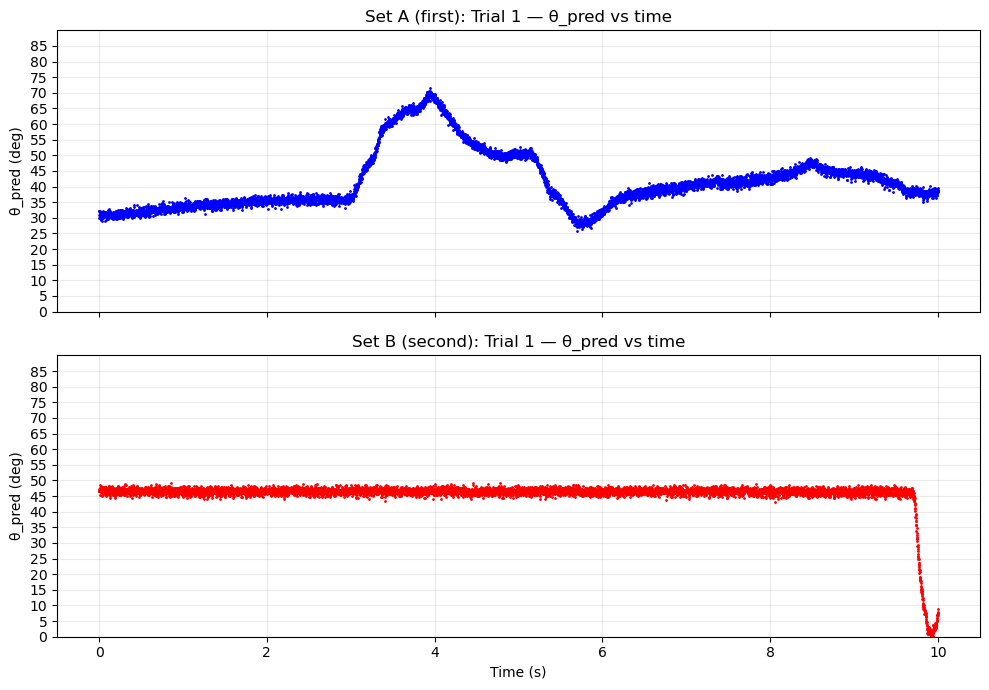

In [88]:
# Plot first trial for both 1st application (blue) and reapplication (red)
# Need to double check with Phil, but first 15 of each should be ball bearing, 16-30 beaker

# Filter trial 1 from each set
A1 = theta_all[(theta_all["set_label"] == "first")  & (theta_all["trial"] == 3)]
B1 = theta_all[(theta_all["set_label"] == "second") & (theta_all["trial"] == 3)]



fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# Top: FIRST set (blue) – trial 1
if not A1.empty:
    axes[0].plot(A1["time_s"], A1["theta_pred_deg"], ".", markersize=2, color="blue")
axes[0].set_title("Set A (first): Trial 1 — θ_pred vs time")
axes[0].set_ylabel("θ_pred (deg)")
axes[0].grid(alpha=0.25)

# Bottom: SECOND set (red) – trial 1
if not B1.empty:
    axes[1].plot(B1["time_s"], B1["theta_pred_deg"], ".", markersize=2, color="red")
axes[1].set_title("Set B (second): Trial 1 — θ_pred vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_pred (deg)")
axes[1].grid(alpha=0.25)

# Fix y-range and ticks
axes[0].set_ylim(0, 90)
axes[1].set_ylim(0, 90)
axes[0].set_yticks(range(0, 90, 5))
axes[1].set_yticks(range(0, 90, 5))

plt.tight_layout()
plt.show()



## Plot all trials together for 1st application and reapplication

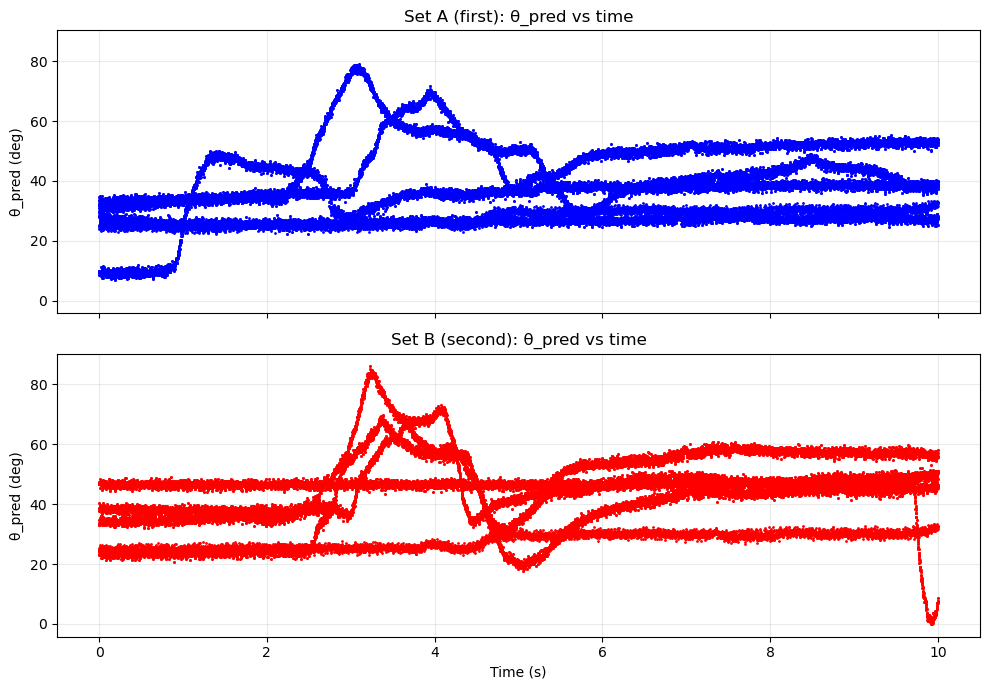

In [90]:
# Plotting all 30 trials 1st application and 1st reapplication data here for strain sensor

# Split by set
A = theta_all[theta_all["set_label"] == "first"]
B = theta_all[theta_all["set_label"] == "second"]

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# Top: FIRST set (blue)
for trial_i in sorted(A["trial"].unique()):
    df = A[A["trial"] == trial_i]
    if not df.empty:
        axes[0].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="blue")
axes[0].set_title("Set A (first): θ_pred vs time")
axes[0].set_ylabel("θ_pred (deg)")
axes[0].grid(alpha=0.25)

# Bottom: SECOND set (red)
for trial_i in sorted(B["trial"].unique()):
    df = B[B["trial"] == trial_i]
    if not df.empty:
        axes[1].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="red")
axes[1].set_title("Set B (second): θ_pred vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_pred (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()


# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*')

In [92]:
# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*')
cam_trials_first  = bb.extract_mat_dfs_by_trial(df_first,  mat_name="flir.mat", prefix="ts")
cam_trials_second = bb.extract_mat_dfs_by_trial(df_second, mat_name="flir.mat", prefix="ts")

print(f"First set:  {len(cam_trials_first)} flir.mat trials")
print(f"Second set: {len(cam_trials_second)} flir.mat trials")

# Access a single trial’s df (like ADC)
trial1_cam = cam_trials_first[0]
print("Trial 1 flir.mat columns:", [] if trial1_cam.empty else list(trial1_cam.columns))

# Waiting for Phil to give me 3d DLC position data

cam_trials_first[0]

[WARN] Skipping unreadable MAT: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\9_19_25\09_19_SEN2_cleaned\sensor_data\2025_09_19_19_46_15_R_mar\flir_data_2025_09_19_19_46_15_R_mar.mat (All arrays must be of the same length)
[WARN] Skipping unreadable MAT: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\9_19_25\2025_09_19_19_46_15_R_mar\flir_data_2025_09_19_19_46_15_R_mar.mat (All arrays must be of the same length)
[WARN] Skipping unreadable MAT: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\9_19_25\09_19_SEN2_cleaned\sensor_data\2025_09_19_19_52_55_R_mar\flir_data_2025_09_19_19_52_55_R_mar.mat (All arrays must be of the same length)
[WARN] Skipping unreadable MAT: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\9_19_25\2025_09_19_19_52_55_R_mar\flir_data_2025_09_19_19_52_55_R_mar.mat (All arrays must be of the same length)
[W

,ts_25183199,ts_25185174
0,1.941363e+11,1.941363e+11
1,1.941363e+11,1.941363e+11
2,1.941364e+11,1.941364e+11
3,1.941364e+11,1.941364e+11
4,1.941365e+11,1.941365e+11


# Match trial ADC timestamps to camera trigger timestamps -> need for error analysis

In [94]:
# Match trial ADC timestamps to camera trigger timestamps -> need for error analysis
# See jupyter notebook camera_encoder_cal.ipnyb.  This file compares the camera 3d data with timestamps to encoder data from autobender with timestamps

aligned_first = bb.align_theta_all_to_cam_for_set(
    theta_all_first, cam_trials_first,
    enc_time_col="timestamp",                # will fall back to 'time'/'t_sec' if needed
    cam_time_col="ts_25185174",              # <— pick the correct one
    tolerance="50ms",                       # start generous
    theta_col="theta_pred_deg",
    drop_unmatched=False,
)

aligned_second = bb.align_theta_all_to_cam_for_set(
    theta_all_second, cam_trials_second,
    enc_time_col="timestamp",                # will fall back to 'time'/'t_sec' if needed
    cam_time_col="ts_25185174",              # <— pick the correct one
    tolerance="50ms",                       # start generous
    theta_col="theta_pred_deg",
    drop_unmatched=False,
)

# Example: trial 3 from each set
t3A = aligned_first[2]
t3B = aligned_second[2]

t3A


,ts_25183199,ts_25185174,_t_ns,timestamp,theta_pred_deg,time_s,adc_ch3,_t_enc_ns,_delta_ns,_delta_ms,_delta_sec,trial,set_label
0,1.943109e+11,1.943109e+11,194310911888,194310917375,32.267810,0.000000,12471400.0,194310917375,5487,0.005487,5.487000e-06,3,first
1,1.943110e+11,1.943110e+11,194310962906,194310961183,30.007187,0.034537,12486248.0,194310961183,-1723,-0.001723,-1.723000e-06,3,first
2,1.943110e+11,1.943110e+11,194311015026,194311015907,29.513590,0.092100,12489490.0,194311015907,881,0.000881,8.810000e-07,3,first
3,1.943111e+11,1.943111e+11,194311068638,194311065649,30.267080,0.141027,12484541.0,194311065649,-2989,-0.002989,-2.989000e-06,3,first
4,1.943111e+11,1.943111e+11,194311122429,194311123456,32.319727,0.200029,12471059.0,194311123456,1027,0.001027,1.027000e-06,3,first
5,1.943112e+11,1.943112e+11,194311175881,194311173348,32.449750,0.250396,12470205.0,194311173348,-2533,-0.002533,-2.533000e-06,3,first


## IMU Analysis of Wrist Bend Angles Here

In [96]:

# 2) Extract IMU trials (same calls as before)
imu_trials_first  = bb.extract_imu_dfs_by_trial(df_first)      # list length = bb.n_trials_per_set
imu_trials_second = bb.extract_imu_dfs_by_trial(df_second)

print(f"First set:  {len(imu_trials_first)} IMU trials")
print(f"Second set: {len(imu_trials_second)} IMU trials")

# 3) Access a single trial (unchanged)
trial1_imu = imu_trials_first[0]   # 0-based index -> trial 1




First set:  9 IMU trials
Second set: 9 IMU trials


## Compute bend angle from two IMU's

[A] non-empty trials: 9, rows: 13131
[B] non-empty trials: 9, rows: 12635


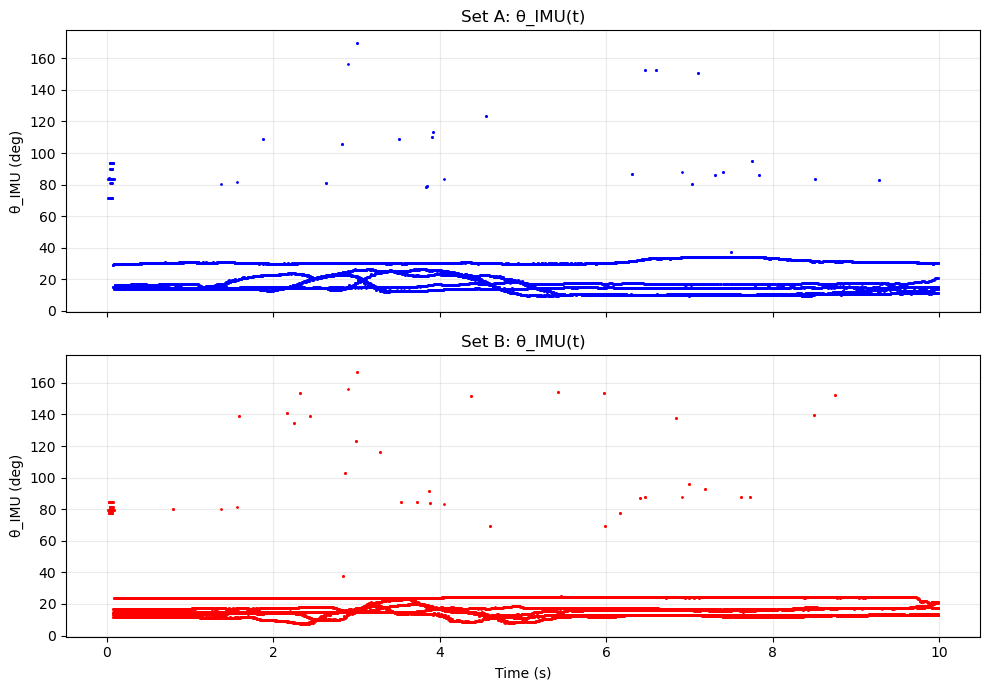

In [98]:
# ========================= IMU → joint-angle math overview =========================
# We mount two IMUs:
#   • IMU1 ("fixed"): reference segment (watch)
#   • IMU2 ("moving"): distal segment (hand/palm)
#
# Each IMU streams orientation as a unit quaternion q = [w, x, y, z] in some order
# (here 'wxyz'; change QUAT_ORDER if your data is 'xyzw'). A unit quaternion
# represents a 3D rotation R(q) with no gimbal lock and stable interpolation.
#
# Goal: compute the bend angle between a chosen axis on the fixed segment and a
# chosen axis on the moving segment, *as seen in the fixed segment’s frame*.
#
# Math (conceptual):
#   1) Convert both quaternions to rotation matrices:
#        R_fixed = R(q_fixed), R_moving = R(q_moving)
#
#   2) Bring the moving frame into the fixed frame via the relative rotation:
#        R_rel = R_fixed^T · R_moving
#
#   3) Choose body axes (e.g., axis pointing down the index-finger direction):
#        e_fix  = unit axis on the fixed body (x/y/z in IMU1's body frame)
#        e_move = unit axis on the moving body (x/y/z in IMU2's body frame)
#        The strings FIXED_AXIS and MOVING_AXIS select which canonical axis ('x', 'y', or 'z').
#
# Notes:
# - Pick axes that align with the physical direction you want to measure (e.g., IMU1's y-axis along forearm, IMU2's x-axis along palm/fingers).
# - If your hardware mounting changes, update FIXED_AXIS/MOVING_AXIS accordingly.

# Examples (choose letters that match how your sensors are physically mounted):
#
# A) Common mounting:
#    - IMU1 (forearm/watch) mounted so its body y-axis points along the forearm (elbow→wrist).
#    - IMU2 (palm) mounted so its body x-axis points down the fingers (wrist→index tip).
#    -> FIXED_AXIS  = "y"   # e_fix = [0,1,0] in IMU1 body frame
#       MOVING_AXIS = "x"   # e_move = [1,0,0] in IMU2 body frame
#
# B) Rolled/yawed mount where IMU1's body z-axis ends up pointing down the index finger:
#    - After mounting, the direction you care about corresponds to IMU1's z-axis.
#    -> FIXED_AXIS  = "z"
#       MOVING_AXIS = "x"   # (or "y"/"z") pick the IMU2 axis that tracks the palm/fingers best
#
# C) IMU2 flipped 180 deg around its y-axis (so x flips sign):
#    - If your angles look inverted, try switching MOVING_AXIS letter:
#    -> previous: MOVING_AXIS = "x"
#       try:      MOVING_AXIS = "z"  (or "y") depending on which axis now aligns with finger direction
#
# D) Both sensors mounted with their x-axes along the limb segments:
#    -> FIXED_AXIS  = "x"
#       MOVING_AXIS = "x"
#
# E) Quick calibration tip:
#    - Hold a neutral pose, compute R_fixed and R_moving from quats.
#    - Test which body axis (x/y/z) for each IMU has the largest dot product with your intended anatomical direction.
#      Pick that letter as FIXED_AXIS / MOVING_AXIS.
#
#   4) Rotate the moving axis into the fixed frame:
#        v = R_rel · e_move
#
#   5) Bend angle is the angle between v and e_fix in the fixed frame:
#        theta = arccos( clamp( v · e_fix, -1, 1 ) )
#
#      • If you need a *signed* angle in a specific plane, you can project onto a plane
#        and use cross products to set the sign. The pipeline here computes a principal
#        (unsigned) angle consistent with the axis choices.
#      • Units: theta is computed in radians then converted to degrees for convenience.
#
# Why axis choices matter:
#   • Your physical mounting determines which body axis of each IMU best tracks the
#     bending direction. For Tom’s data, IMU1 (watch) was against a vertical wall and
#     IMU2 (palm) faced along the hand toward the fingers, so FIXED_AXIS and MOVING_AXIS
#     are set to align with those physical directions. If your mounting changes, update
#     FIXED_AXIS/MOVING_AXIS to match the true “bend” axes.
#
# Quaternion order:
#   • Many devices output [x, y, z, w] (xyzw) while math libraries prefer [w, x, y, z] (wxyz).
#     QUAT_ORDER tells the code how to read your columns and map them correctly before
#     building R(q). If this is wrong, the computed angle will be nonsense.
#



# ---- IMU processing params  ----
TRIAL_LEN_SEC = 10.0                 # trial duration (s) used to synthesize time_s if needed
QUAT_COLS     = ("quat1", "quat2")   # names of the two quaternion columns/blocks (IMU1, IMU2)
                                      # (or use ("euler1","euler2") if your pipeline expects eulers there)

# For Tom's setup:
#   - IMU1 (watch) placed against a vertical wall (reference segment)
#   - IMU2 (palm) facing down the hand axis toward the fingers (moving segment)
# The chosen axes below reflect those mountings. Adjust if your hardware orientation changes.
FIXED_AXIS    = "y"                  # body axis of IMU1 used as the reference direction (e_fix)
MOVING_AXIS   = "x"                  # body axis of IMU2 whose motion defines the bend (e_move)
QUAT_ORDER    = "wxyz"               # order of quaternion components in your columns ('wxyz' or 'xyzw')

# 3) Compute joint angle per trial, in place (adds: time_s, imu_joint_deg_rx_py)
bb.imu_augment_trials_inplace(
    aligned_first,            # kept for API symmetry; not used internally
    imu_trials_first,
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)
bb.imu_augment_trials_inplace(
    aligned_second,
    imu_trials_second,
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)

# 4) Build tall (long-form) frames for plotting/analysis.
#    imu_collect_tall(...) re-runs the same geometry on the provided trials and returns a
#    concatenated dataframe with columns like:
#      ['set_label','trial','time_s','timestamp','imu_joint_deg_rx_py', ...]
A_all = bb.imu_collect_tall(
    imu_trials_first, "first",
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)
B_all = bb.imu_collect_tall(
    imu_trials_second, "second",
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)


print(f"[A] non-empty trials: {A_all['trial'].nunique() if not A_all.empty else 0}, rows: {len(A_all)}")
print(f"[B] non-empty trials: {B_all['trial'].nunique() if not B_all.empty else 0}, rows: {len(B_all)}")

# 5) Quick plot
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

for tr in (sorted(A_all["trial"].unique()) if not A_all.empty else []):
    d = A_all[A_all["trial"] == tr]
    axes[0].plot(d["time_s"], d["imu_joint_deg_rx_py"], ".", markersize=2, color="blue")
axes[0].set_title("Set A: θ_IMU(t)")
axes[0].set_ylabel("θ_IMU (deg)")
axes[0].grid(alpha=0.25)

for tr in (sorted(B_all["trial"].unique()) if not B_all.empty else []):
    d = B_all[B_all["trial"] == tr]
    axes[1].plot(d["time_s"], d["imu_joint_deg_rx_py"], ".", markersize=2, color="red")
axes[1].set_title("Set B: θ_IMU(t)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_IMU (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()



## Plot single trial IMU bend angle data

C:\Users\toppe\AppData\Local\Temp\ipykernel_25756\1337192289.py:3: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  A1 = A_all[(~A_all.empty) & (A_all["trial"] == trial_id)] if not A_all.empty else A_all
C:\Users\toppe\AppData\Local\Temp\ipykernel_25756\1337192289.py:4: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  B1 = B_all[(~B_all.empty) & (B_all["trial"] == trial_id)] if not B_all.empty else B_all


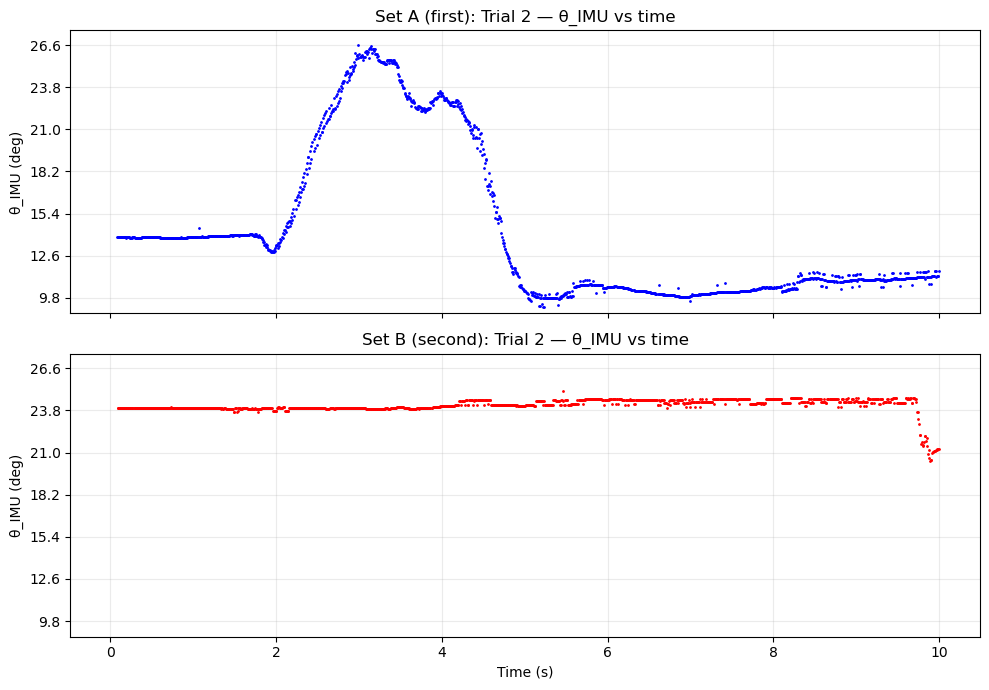

In [100]:
trial_id = 2  # pick a trial index

A1 = A_all[(~A_all.empty) & (A_all["trial"] == trial_id)] if not A_all.empty else A_all
B1 = B_all[(~B_all.empty) & (B_all["trial"] == trial_id)] if not B_all.empty else B_all

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# FIRST set (blue)
if A1 is not None and not A1.empty:
    axes[0].plot(A1["time_s"], A1["imu_joint_deg_rx_py"], ".", markersize=2, color="blue")
axes[0].set_title(f"Set A (first): Trial {trial_id} — θ_IMU vs time")
axes[0].set_ylabel("θ_IMU (deg)")
axes[0].grid(alpha=0.25)

# SECOND set (red)
if B1 is not None and not B1.empty:
    axes[1].plot(B1["time_s"], B1["imu_joint_deg_rx_py"], ".", markersize=2, color="red")
axes[1].set_title(f"Set B (second): Trial {trial_id} — θ_IMU vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_IMU (deg)")
axes[1].grid(alpha=0.25)

# Optional: auto y-limits if data exist; otherwise keep a default
vals = pd.concat(
    [A1["imu_joint_deg_rx_py"]] if (A1 is not None and not A1.empty) else [] +
    [B1["imu_joint_deg_rx_py"]] if (B1 is not None and not B1.empty) else [],
    ignore_index=True
) if ((A1 is not None and not A1.empty) or (B1 is not None and not B1.empty)) else None

if vals is not None and vals.notna().any():
    lo = float(np.nanpercentile(vals, 1))
    hi = float(np.nanpercentile(vals, 99))
    pad = max(1.0, 0.05 * (hi - lo))
    for ax in axes:
        ax.set_ylim(lo - pad, hi + pad)
        ax.set_yticks(np.linspace(round(lo, 1), round(hi, 1), 7))
else:
    for ax in axes:
        ax.set_ylim(0, 30)
        ax.set_yticks(range(0, 31, 5))

plt.tight_layout()
plt.show()
